In [0]:
import sys 
sys.version


'3.6.3 (default, Oct  3 2017, 21:45:48) \n[GCC 7.2.0]'

In [62]:
# Install PyTorch
# I haven't needed to do this, but here's how just in case.
!pip3 install http://download.pytorch.org/whl/cu80/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl 
!pip3 install torchvision

In [63]:
!pip3 install fastai


In [0]:
from fastai.transforms import * 
from fastai.conv_learner import * 
from fastai.model import * 
from fastai.dataset import * 
from fastai.sgdr import * 
from fastai.plots import * 

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.imports import * 


In [0]:
# Get the file from fast.ai URL, unzip it, and put it into the folder 'data'
# This uses -qq to make the unzipping less verbose.
!wget http://files.fast.ai/data/dogscats.zip && unzip -qq dogscats.zip -d data/


Redirecting output to ‘wget-log’.


In [22]:
!ls


data  dogscats.zip  dogscats.zip.1  sample_data  wget-log  wget-log.1


if you do not use -qq after unzip you get verbose details of the unizip.

In [0]:
!ls 


data  dogscats.zip  sample_data  wget-log


In [0]:
!cd data
!ls

data  dogscats.zip  sample_data  wget-log


In [23]:
!ls data/dogscats


models	sample	test1  train  valid


In [0]:
PATH = "data/dogscats/"

In [0]:
sz=224

In [26]:
!ls {PATH}

models	sample	test1  train  valid


In [27]:
!ls {PATH}valid

cats  dogs


In [28]:
files =!ls {PATH}valid/cats |head
files


['cat.10016.jpg',
 'cat.1001.jpg',
 'cat.10026.jpg',
 'cat.10048.jpg',
 'cat.10050.jpg',
 'cat.10064.jpg',
 'cat.10071.jpg',
 'cat.10091.jpg',
 'cat.10103.jpg',
 'cat.10104.jpg']

In [0]:
import matplotlib.pyplot as plt
from matplotlib import*


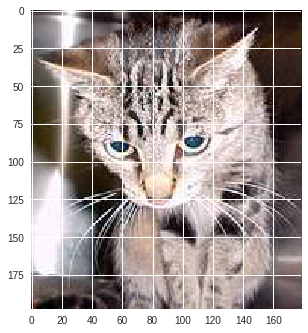

In [30]:
img = plt.imread(f'{PATH}valid/cats/{files[0]}')
plt.imshow(img)

In [32]:
img.shape


(198, 179, 3)

In [31]:
img[:4,:4]

array([[[ 29,  20,  23],
        [ 31,  22,  25],
        [ 34,  25,  28],
        [ 37,  28,  31]],

       [[ 60,  51,  54],
        [ 58,  49,  52],
        [ 56,  47,  50],
        [ 55,  46,  49]],

       [[ 93,  84,  87],
        [ 89,  80,  83],
        [ 85,  76,  79],
        [ 81,  72,  75]],

       [[104,  95,  98],
        [103,  94,  97],
        [102,  93,  96],
        [102,  93,  96]]], dtype=uint8)

In [34]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(resnet34, sz))
learn = ConvLearner.pretrained(resnet34, data, precompute=True)
learn.fit(0.01, 3)


epoch      trn_loss   val_loss   accuracy   
    0      0.051609   0.027026   0.9915    
    1      0.042292   0.025423   0.991     
    2      0.038645   0.027312   0.9895    



[array([0.02731]), 0.9895]

In [35]:
data.classes


['cats', 'dogs']

In [37]:
data.val_y

array([0, 0, 0, ..., 1, 1, 1])

In [38]:
log_preds=learn.predict()
log_preds.shape

(2000, 2)

In [40]:
log_preds[:10]

array([[ -0.00246,  -6.00706],
       [ -0.00595,  -5.12751],
       [ -0.01635,  -4.12147],
       [ -0.00068,  -7.2878 ],
       [ -0.00142,  -6.55649],
       [ -0.00008,  -9.46836],
       [ -0.00006,  -9.70904],
       [ -0.00034,  -7.97765],
       [ -0.00003, -10.48227],
       [ -0.00011,  -9.07288]], dtype=float32)

In [0]:
preds = np.argmax(log_preds,axis=1)
probs=np.exp(log_preds[:,1])

In [0]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], min(len(preds), 4), replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

In [0]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])


In [0]:
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8)) if len(imgs)>0 else print('Not Found.')

Correctly classified


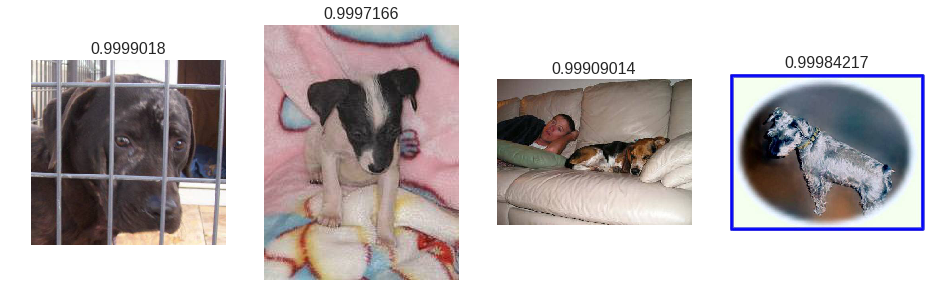

In [52]:
# 1. A few correct labels at random plot_val_with_title(rand_by_correct(True), "Correctly classified")
plot_val_with_title(rand_by_correct(True), "Correctly classified")


Incorrectly classified


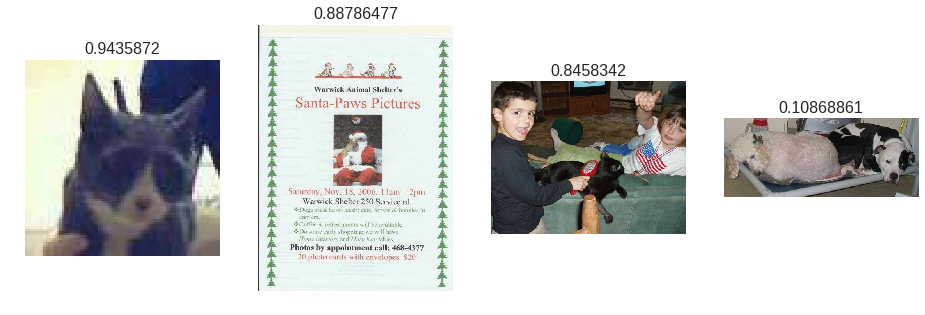

In [53]:
# 2. A few incorrect labels at random
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")


In [0]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

Most correct cats


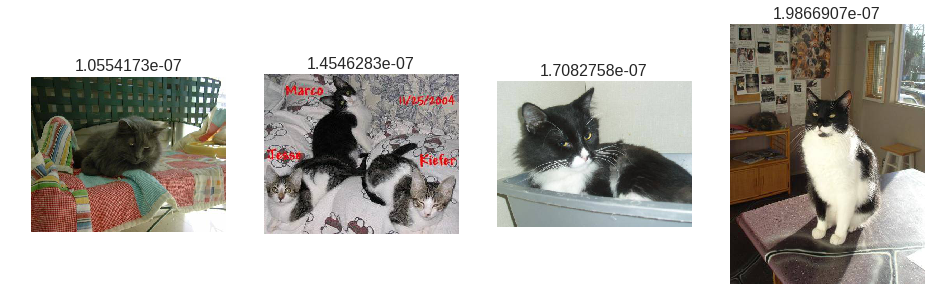

In [55]:
plot_val_with_title(most_by_correct(0, True), "Most correct cats")


Most correct dogs


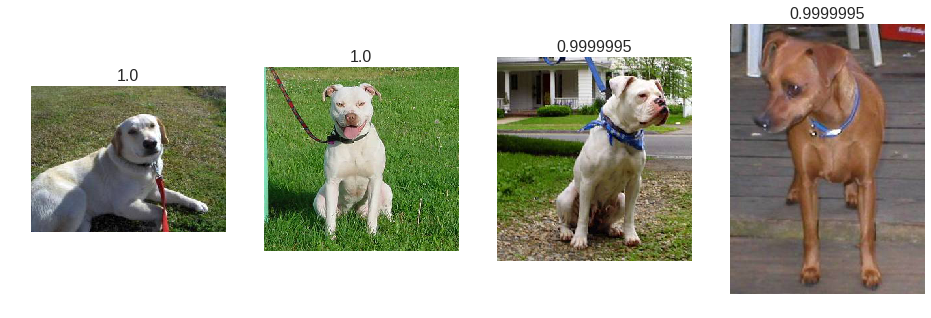

In [56]:
plot_val_with_title(most_by_correct(1, True), "Most correct dogs")


Most incorrect cats


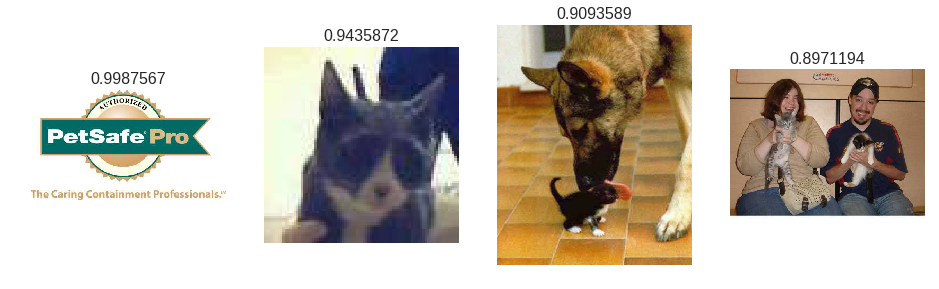

In [57]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect cats")


Most incorrect dogs


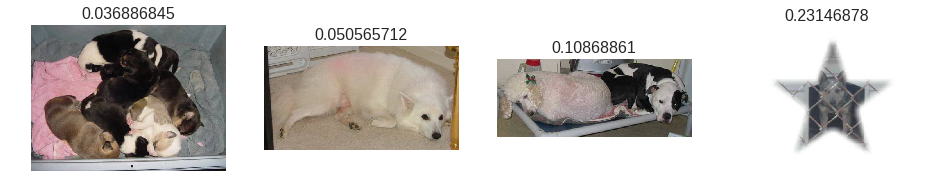

In [58]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect dogs")


Most uncertain predictions


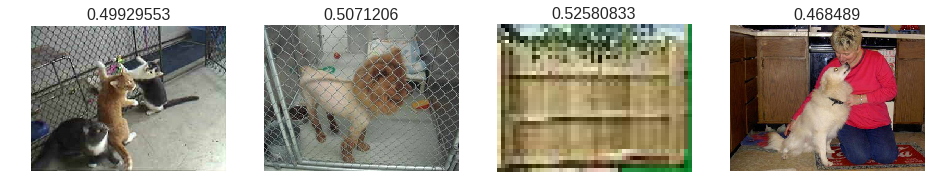

In [59]:
most_uncertain = np.argsort(np.abs(probs -0.5))[:4]
plot_val_with_title(most_uncertain, "Most uncertain predictions")


In [0]:
arch = resnet34
learn = ConvLearner.pretrained(arch, data, precompute=True)


In [71]:
lrf=learn.lr_find()


 83%|████████▎ | 298/360 [00:08<00:01, 40.48it/s, loss=0.444]


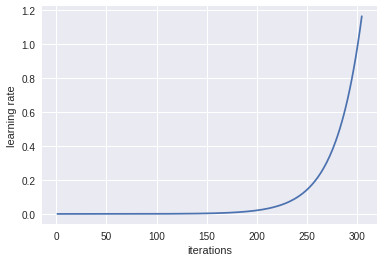

In [72]:
learn.sched.plot_lr()


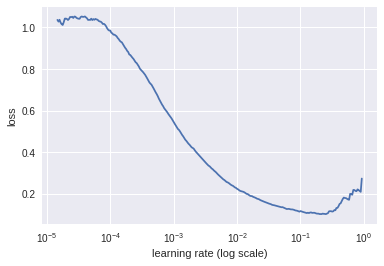

In [73]:
learn.sched.plot()


In [0]:
tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_side_on, max_zoom=1.1)


In [0]:
def get_augs():
    data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms, num_workers=1)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

In [0]:
ims = np.stack([get_augs() for i in range(6)])


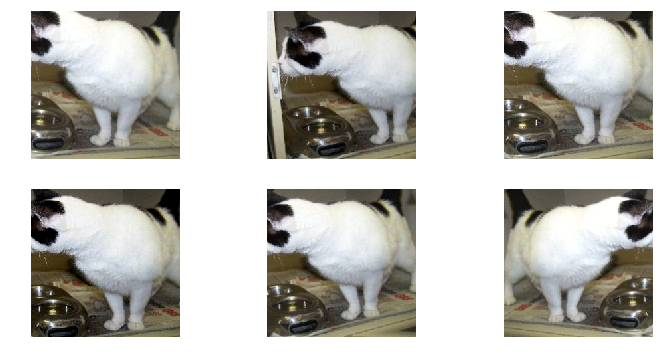

In [77]:
plots(ims, rows=2)


In [0]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms)
learn = ConvLearner.pretrained(arch, data, precompute=True)


In [79]:
learn.fit(1e-2, 1)


epoch      trn_loss   val_loss   accuracy   
    0      0.057774   0.026586   0.9895    



[array([0.02659]), 0.9895]

In [0]:
learn.precompute=False


In [0]:
learn.fit(1e-2, 3, cycle_len=1)


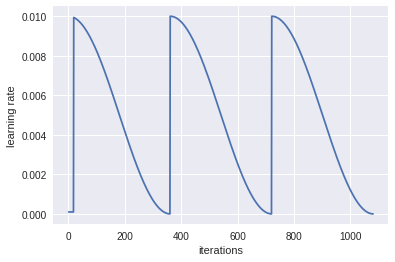

In [82]:
learn.sched.plot_lr()


In [0]:
learn.save('224_lastlayer')


In [0]:
learn.load('224_lastlayer')


In [0]:
learn.unfreeze()

In [0]:
lr=np.array([1e-4,1e-3,1e-2])


In [121]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)


epoch      trn_loss   val_loss   accuracy   
    0      0.028444   0.023162   0.9905    
    1      0.022612   0.024586   0.9885    
    2      0.021737   0.023446   0.991     
    3      0.026889   0.026209   0.9895    
    4      0.020195   0.024517   0.9905    
    5      0.025251   0.024414   0.9925    
    6      0.02622    0.024267   0.99      


[array([0.02427]), 0.99]

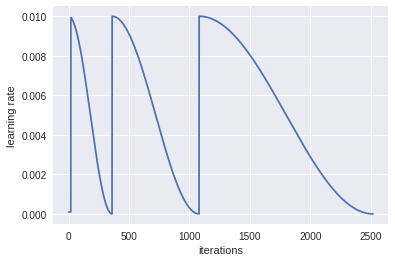

In [122]:
learn.sched.plot_lr()


In [0]:
learn.save('224_all')


In [0]:
learn.load('224_all')


In [93]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)

In [94]:
accuracy_np(probs, y)


0.99

In [0]:

preds = np.argmax(probs, axis=1)
probs = probs[:,1]

In [0]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

[[986  14]
 [  6 994]]


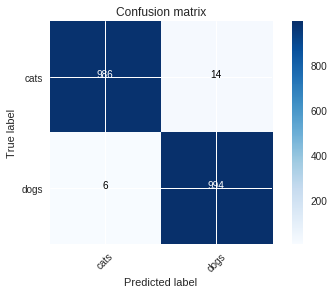

In [97]:
plot_confusion_matrix(cm, data.classes)


Most incorrect cats


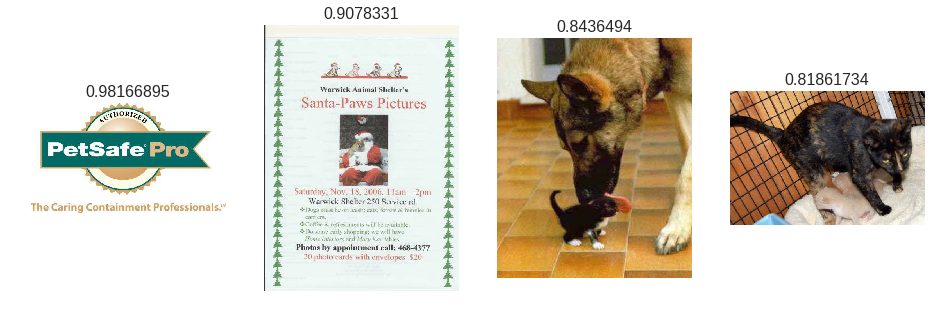

In [103]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect cats")


Most incorrect dogs


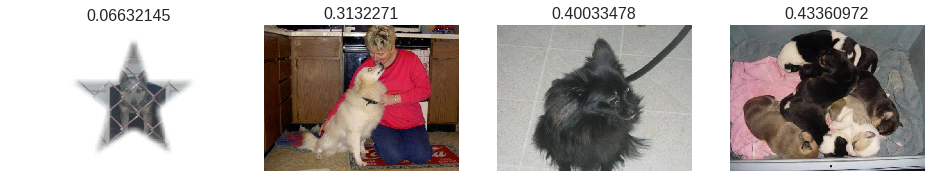

In [104]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect dogs")


In [0]:
tfms = tfms_from_model(resnet34, sz)


In [0]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms)


In [0]:
learn = ConvLearner.pretrained(resnet34, data, precompute=True)


In [108]:
learn.fit(1e-2, 1)


epoch      trn_loss   val_loss   accuracy   
    0      0.054001   0.028394   0.9895    


[array([0.02839]), 0.9895]

In [0]:
def binary_loss(y, p):
    return np.mean(-(y * np.log(p) + (1-y)*np.log(1-p)))


In [111]:
acts = np.array([1, 0, 0, 1])
preds = np.array([0.9, 0.1, 0.2, 0.8])
binary_loss(acts, preds)

0.164252033486018